# Sentiment analysys of brazilian presidential candidates of 2022

## In this project we are going to analyse tweets mentioning the 2 most popular candidates in presidential elections.

<p>In order to perfom this analysis I created some custom functions to make the code cleaner and more objective. All of these functions are on "my_library.py" file. 
<p>The data in use has been saven in the cloud, on AWS MYSQL database.
<p>The access keys of the database and twitter api are stored in the corresponding json files

In [25]:
import json
import pandas as pd
import tweepy as tw
from textblob import TextBlob
from googletrans import Translator
from unidecode import unidecode
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
import re
import pymysql
from my_library import *
import matplotlib.pyplot as plt

# Getting data from aws MySQL

In order to get our data from aws we need the login information, that is stored in a json file for security reasons. The file name is aws_mysql_key.json
We are going to load the information into some variables

In [2]:
with open("aws_mysql_key.json") as aws_keys:
    keys = json.load(aws_keys)
    aws_user = keys['user']
    aws_password = keys['password']
    aws_endpoint = keys['endpoint']
    aws_dbname = keys['databasename']

<b>Now that we have the info from aws we can create the dataset. First we will get all the items from tables Lula and Bolsonaro

In [3]:
bolsonaro_data = get_items_aws("Bolsonaro",
                              aws_endpoint,
                              aws_user,
                              aws_password,
                              aws_dbname)

lula_data = get_items_aws("Lula",
                              aws_endpoint,
                              aws_user,
                              aws_password,
                              aws_dbname)

<b>After importing the data we need to mold it so we can work on the dataset. Let's see the first item

In [4]:
bolsonaro_data[0]

(1,
 "@jairbolsonaro @govbr Why haven't they put the Tax on large fortunes into effect yet?")

<b>As we can see the return data is a tuple os 2 elements: a number corresponding to the index ans the text itself. We just need the text:

In [5]:
bolsonaro_data = tuple([row[1:] for row in bolsonaro_data])
lula_data = tuple([row[1:] for row in lula_data])

In [6]:
print(bolsonaro_data[0])

("@jairbolsonaro @govbr Why haven't they put the Tax on large fortunes into effect yet?",)


<b>Our data has just the text we need. The next step is to create a Pandas DataFrame 

In [7]:
lula_df = pd.DataFrame(lula_data, index=None)
bolsonaro_df = pd.DataFrame(bolsonaro_data, index=None)

In [8]:
lula_df.head()

,0
0,@LulaOficial @alexandrekalil @ricardostuckert ...
1,@floresdepapel6 @IracemaFH @LulaOficial There ...
2,@LulaOficial The left has always made a stand ...
3,@AntifaCruzeiro @julioAguiarJC @LulaOficial @a...
4,@Marcos29898805 @AndreiaSAzul @LulaOficial @Dr...


In [9]:
bolsonaro_df.head()

,0
0,@jairbolsonaro @govbr Why haven't they put the...
1,@tati_anacosta @jairbolsonaro We will have!!! ...
2,@diogocosta @jairbolsonaro The hard thing is t...
3,@ElaineApdaSilv2 @jairbolsonaro If you look fo...
4,@dramayraoficial @jairbolsonaro Pará


# Cleaning the data

<b>There are 2 different dataframes, one for Bolsonaro and another for Lula. For better sentiment analysis we need to clean the tweets. We are going to use our custom preprocessing pipeline that perfomrs:
    <br>-weird characters and ponctuation removal
    <br>-remove stop words
    <br>-stemming

In [10]:
#Removing duplicates:
bolsonaro_df.describe()

,0
count,9367
unique,8782
top,@jairbolsonaro DO YOU KNOW WHY LULA IS NOT CON...
freq,15


In [14]:
lula_df.drop_duplicates(inplace=True)
bolsonaro_df.drop_duplicates(inplace=True)

In [15]:
lula_df.describe()

,0
count,9124
unique,9124
top,@LulaOficial @alexandrekalil @ricardostuckert ...
freq,1


In [16]:
lula_df [0] = [preprocess_data_pipe(x) for x in lula_df[0]]
bolsonaro_df[0] = [preprocess_data_pipe(x) for x in bolsonaro_df[0]]

In [17]:
bolsonaro_df.head()

,0
0,put tax larg foun effect yet
1,anacost eah magnetic pol returning real plac g...
2,hard thing find good
3,look information old newspap know robbery ptis...
4,par


# Sentiment analysis

<b> Now we are ready to perform sentiment analysis on the dataframe. 
We are going to create a new column storing the result of TextBlob

In [18]:
lula_df[1] = [transform_sentiment_classes(x) for x in lula_df[0]]
bolsonaro_df[1] = [transform_sentiment_classes(x) for x in bolsonaro_df[0]]

In [19]:
lula_df.head()

,0,1
0,diy thief commitment lie corruption ptralh org...,neutral
1,repo photograph suppo good morning nand,positive
2,left alway mad stand dead,negative
3,pay sh tax send pix,neutral
4,asked question propos futur past want know pla...,negative


<b>In politics we have a lot of news that can be neutral but we are only interested in people's opinion about the candidates. So now let's drop the neutral tweets represented by 'neutral' in the second column

In [20]:
lula_df.drop(lula_df[lula_df[1] == 'neutral'].index, inplace=True)
bolsonaro_df.drop(bolsonaro_df[bolsonaro_df[1] == 'neutral'].index, inplace=True)

In [21]:
lula_df.head()

,0,1
1,repo photograph suppo good morning nand,positive
2,left alway mad stand dead,negative
4,asked question propos futur past want know pla...,negative
7,built universiti bricklay architect engine etc...,positive
11,good morning l,positive


In [22]:
bolsonaro_df.head()

,0,1
1,anacost eah magnetic pol returning real plac g...,positive
2,hard thing find good,positive
3,look information old newspap know robbery ptis...,positive
5,evil person,negative
8,penitentiari brazil build 100 spac form expans...,positive


# Visualizing the results

<b>After all the steps, now is the time to show the final results by ploting the percentage of negative and positive tweets of each candidate

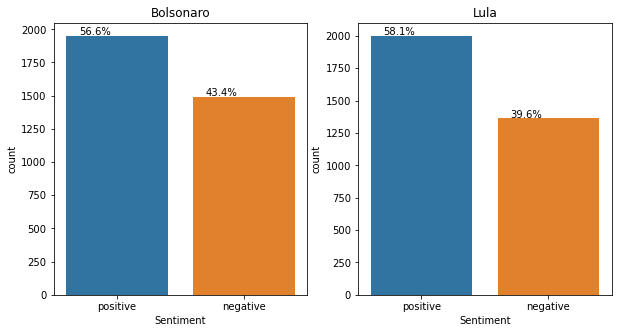

In [64]:

fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.countplot(x=1, data=bolsonaro_df,ax=ax[0])
sns.countplot(x=1, data=lula_df,ax=ax[1])
ax[0].set_title("Bolsonaro")
ax[1].set_title("Lula")
ax[0].set_xlabel("Sentiment")
ax[1].set_xlabel("Sentiment")

#Loops for inserting percentage on top of each bar
for p in ax[0].patches:
        ax[0].annotate('{:.1f}%'.format(100*p.get_height()/len(bolsonaro_df)), (p.get_x()+0.1, p.get_height()+5))
for p in ax[1].patches:
        ax[1].annotate('{:.1f}%'.format(100*p.get_height()/len(bolsonaro_df)), (p.get_x()+0.1, p.get_height()+5))